**The Problem:**

Data analysis of direct market campaign can facilitate Following:
1. Segmentation and targeting.
2. Expense optimization of such future campaigns
3. Sales forecasting.

Here we are going to discuss a problem of cliet conversion classification. Given data about a client response to direct market campaign, what is likelihood of a client to buy the product.







**Available data:**

In this problem we will be looking at the responses of different age group, gender and interest towards a product. The data is collected from the Kaggle website 'Sales conversion optimization'.

The file conversion_data.csv contains 1143 observations in 11 variables. Below are the descriptions of the variables.

1.) ad_id: an unique ID for each ad.

2.) xyzcampaignid: an ID associated with each ad campaign of XYZ company.

3.) fbcampaignid: an ID associated with how Facebook tracks each campaign.

4.) age: age of the person to whom the ad is shown.

5.) gender: gender of the person to whom the add is shown.

6.) interest: a code specifying the category to which the person’s interest belongs (interests are as mentioned in the person’s Facebook public profile).

7.) Impressions: the number of times the ad was shown.

8.) Clicks: number of clicks on for that ad.

9.) Spent: Amount paid by company xyz to Facebook, to show that ad.

10.) Total conversion: Total number of people who enquired about the product after seeing the ad.

11.) Approved conversion: Total number of people who bought the product after seeing the ad.

In [1]:
#Mount the google drive
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks')
%cd /content/drive/My Drive/Colab Notebooks

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks


We want to be able to predict conversion on showing a particular ad to clients with particular interest, age-groups, and gender. 

Along the way we will see the dependencies of data on each other and other relevant information for client sengmentation.

Client segmentation will also give us some idea about how to set up the model. For now we say we are looking for a SVM classification.

In [9]:
# Load the data to the pandas dataframe
import pandas as pd
import csv
import json
from pandas.io.json import json_normalize
df=pd.read_csv('KAG_conversion_data.csv')


**EDA**

Let's have a general look at the data.

In [ ]:
# Check if duplicates are there.
df.duplicated('fb_campaign_id')
df.duplicated('ad_id')



In [5]:
#Check the max min and other stats of data
df.describe()

,ad_id,xyz_campaign_id,fb_campaign_id,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
count,1.143000e+03,1143.000000,1143.000000,1143.000000,1.143000e+03,1143.000000,1143.000000,1143.000000,1143.000000
mean,9.872611e+05,1067.382327,133783.989501,32.766404,1.867321e+05,33.390201,51.360656,2.855643,0.944007
std,1.939928e+05,121.629393,20500.308622,26.952131,3.127622e+05,56.892438,86.908418,4.483593,1.737708
min,7.087460e+05,916.000000,103916.000000,2.000000,8.700000e+01,0.000000,0.000000,0.000000,0.000000
25%,7.776325e+05,936.000000,115716.000000,16.000000,6.503500e+03,1.000000,1.480000,1.000000,0.000000
50%,1.121185e+06,1178.000000,144549.000000,25.000000,5.150900e+04,8.000000,12.370000,1.000000,1.000000
75%,1.121804e+06,1178.000000,144657.500000,31.000000,2.217690e+05,37.500000,60.025000,3.000000,1.000000
max,1.314415e+06,1178.000000,179982.000000,114.000000,3.052003e+06,421.000000,639.949998,60.000000,21.000000


We need to verify if there are any missing data in the dataset. If yes can we ignore those variables or impute the missing values.

There are no missing values in the dataset. we can also verify it with CSV file that we uploaded.

Pandas considers missing values as 1 for multiplication and 0 for addition.

In [7]:
df.isna() # we can check the entire dataset.

,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
0,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
1138,False,False,False,False,False,False,False,False,False,False,False
1139,False,False,False,False,False,False,False,False,False,False,False
1140,False,False,False,False,False,False,False,False,False,False,False
1141,False,False,False,False,False,False,False,False,False,False,False


To have a better idea about customer base we can plot different variables with age and gender. This will help in segmentation of clients.

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
# list out all the different variables types
cat_var=['gender','age','xyz_campaign_id']
numeric_var=df.drop(['gender','age','fb_campaign_id','ad_id'],axis=1).columns.values


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


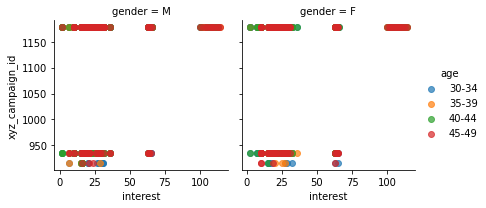

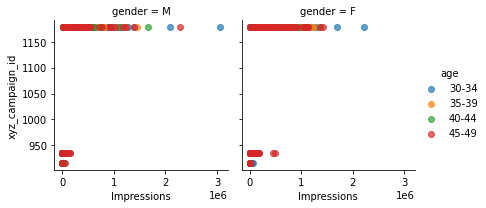

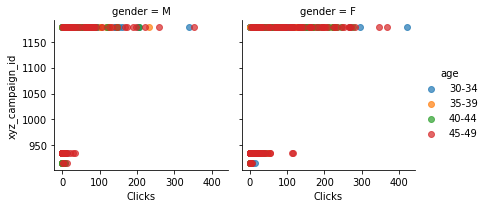

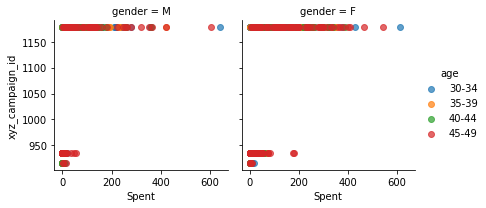

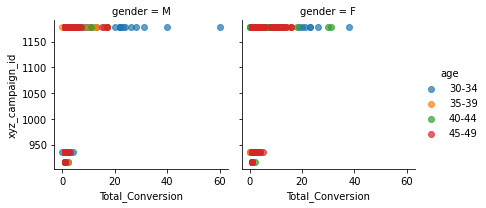

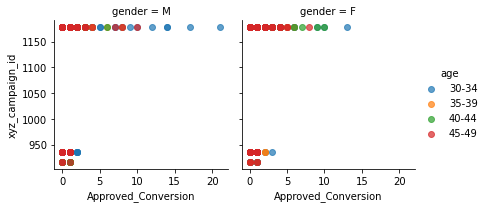

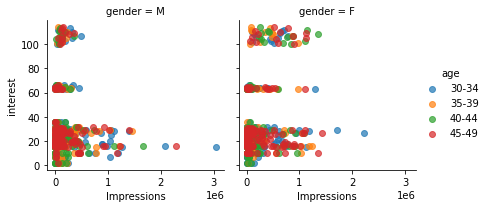

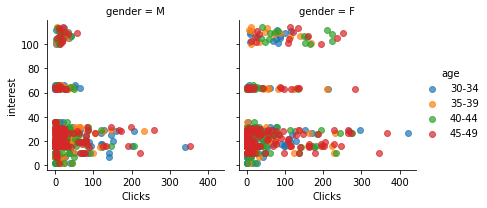

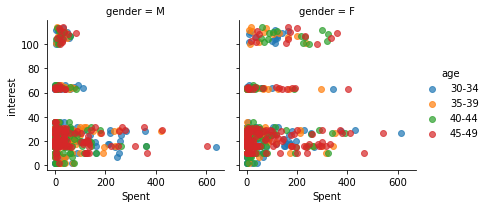

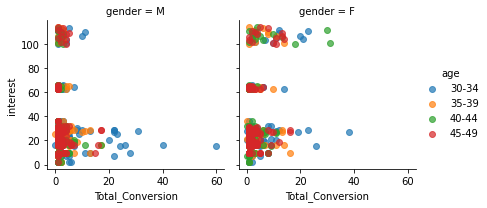

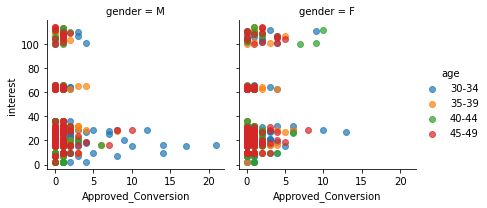

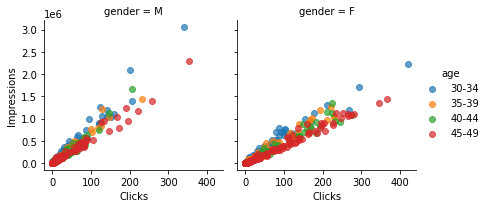

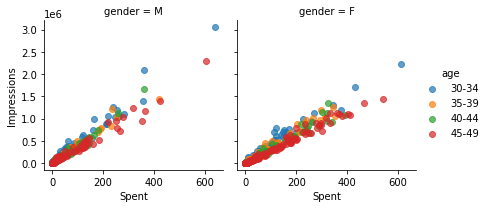

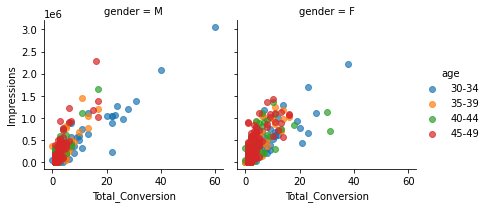

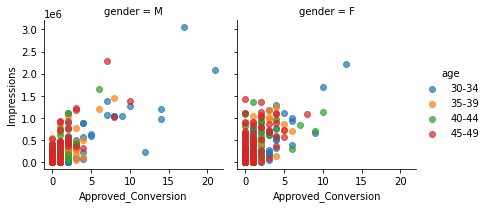

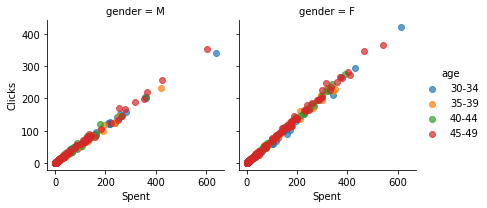

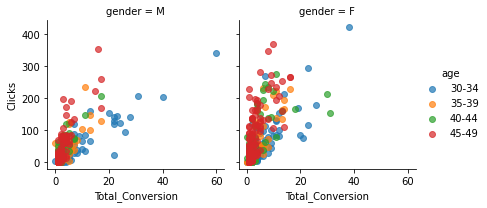

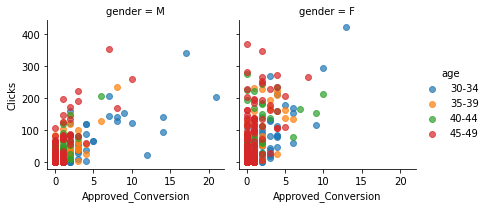

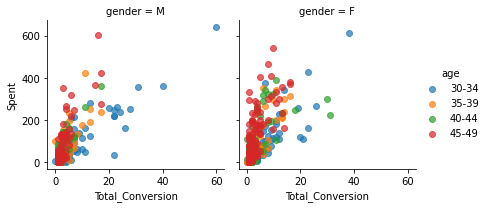

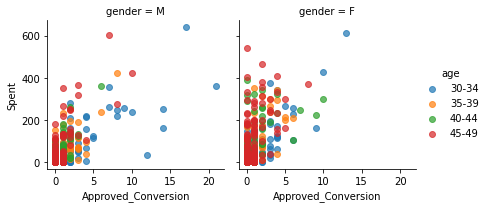

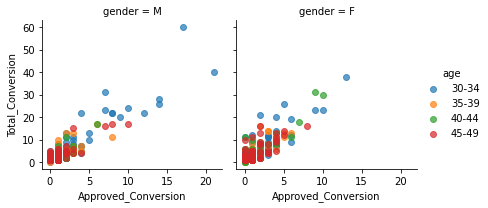

In [4]:
#scatter plots of different numeric variables 
for j in range(0,len(numeric_var)):  
  for i in range(j+1,len(numeric_var)):
    g = sns.FacetGrid(df, col='gender', hue='age')
    g.map(plt.scatter, numeric_var[i], numeric_var[j], alpha=.7)  
    g.add_legend();

The above plots reveal following information:
1. Campain ID 1178 has highest span over interests. Specific ads are more appealing to woman that was exclusively facilitated by campaign 1178.

1. Interests between 0-40 have biggest chunk of clicks.

2. For some 'Interest' numbers near and above 100, women's  number of clicks are higher in numbers.

3. Age group 45-49 in both male and female, conversion per click is least. So more money was spent on ads per conversion.

4. Conversion per click in age group 30-34 is more in males than females.

5. Woman click more than men on ads.

6. Most of approved conversion is between 0 and 5

7. We can remove 'spent' variable as it is linear with 'clicks'.

8. More money is 'Spent' by company on adds seen by females than males.

9. Clicks, impressions and spent have linear relationship. So we can remove any two of these. But that's not the concern right now!

There are other such inferences we can make from visual inspection of data scatter plots.

We will see how histograms can be exploited to produce further insight to the data.




We can try other visualizations by changing the plot parameters. And that may further speak something. We will change hue and check gender-wise visual segreggation.



/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


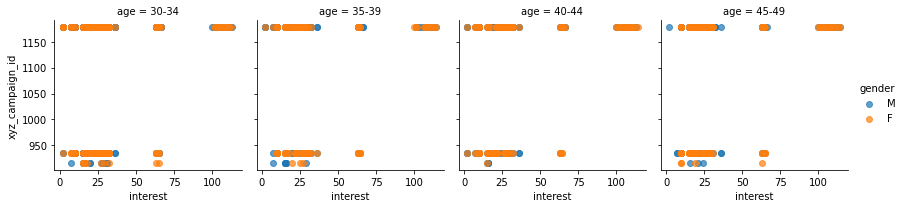

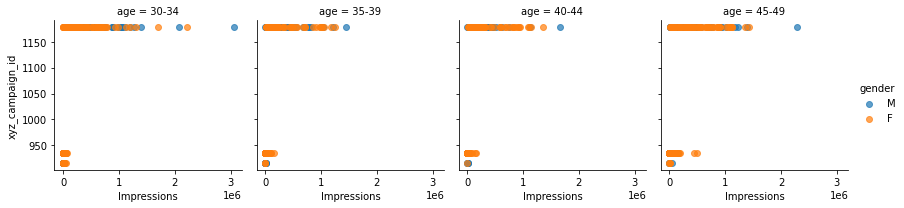

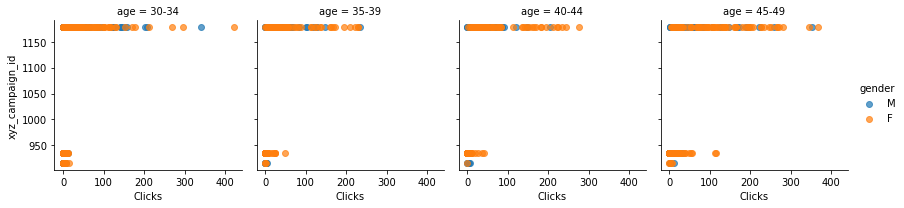

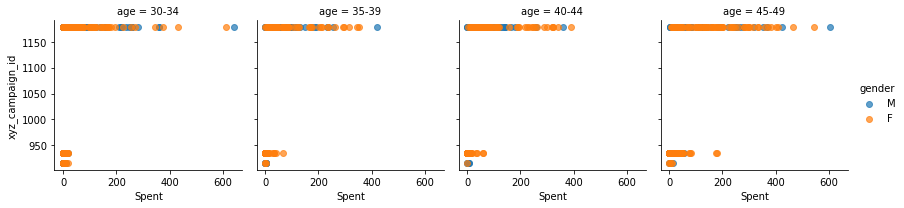

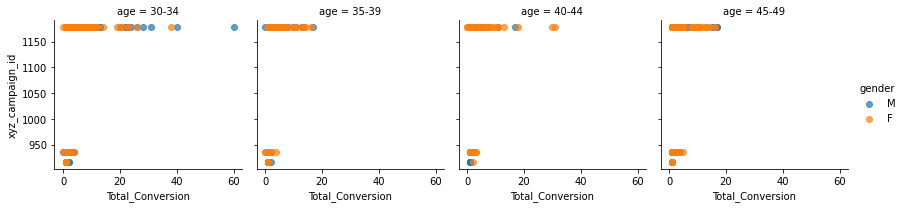

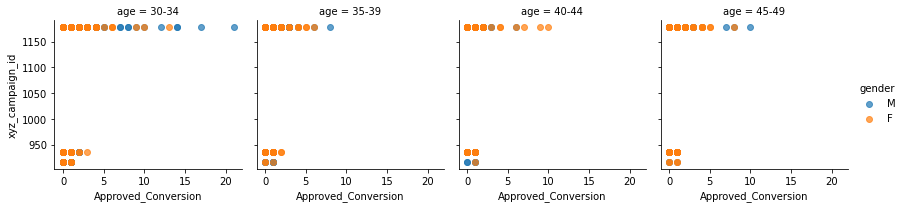

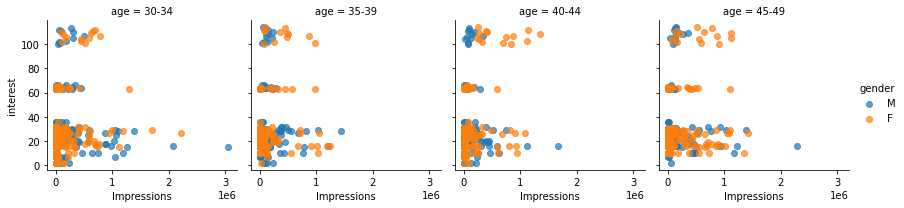

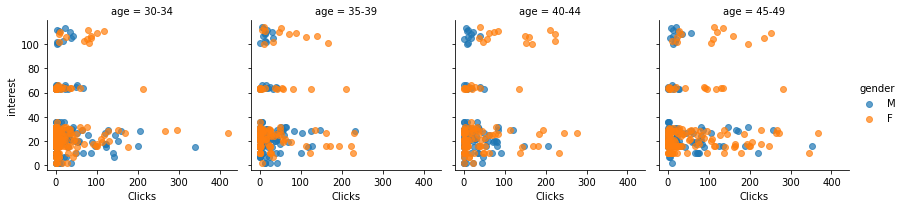

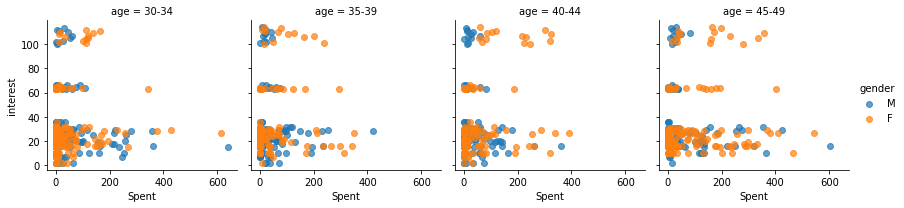

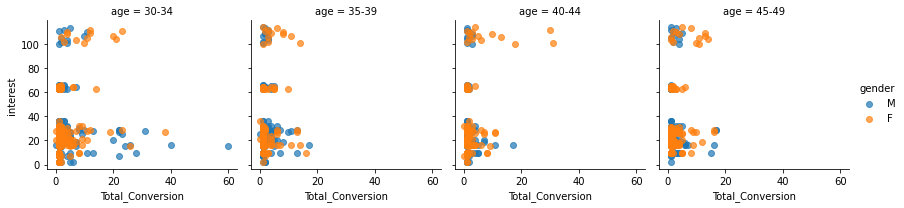

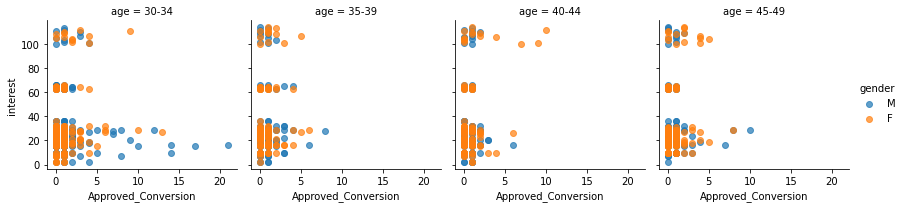

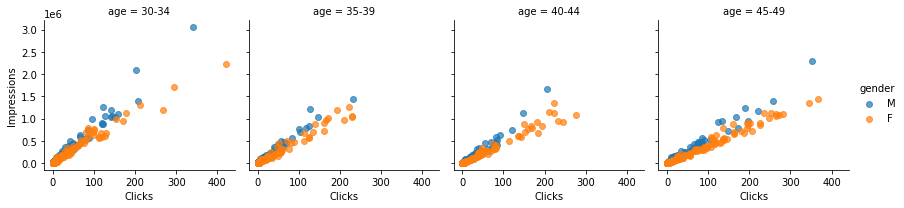

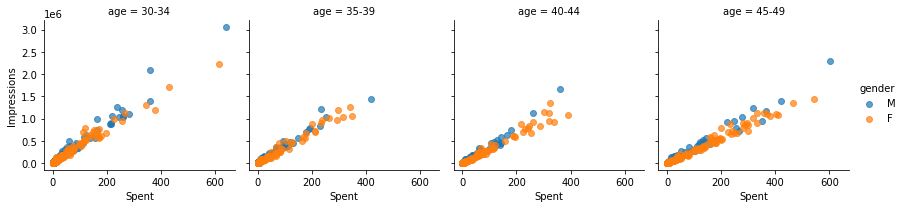

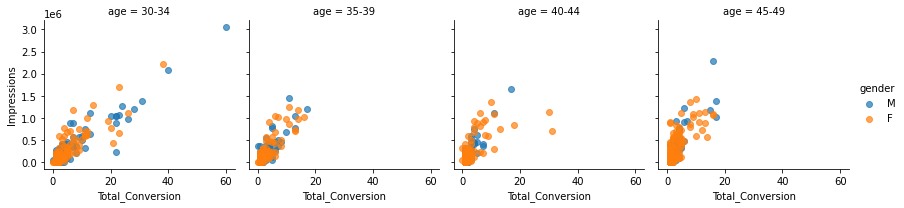

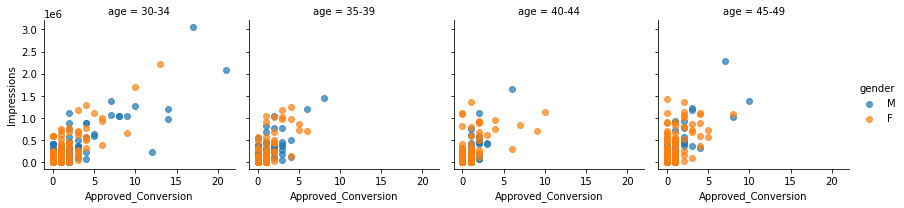

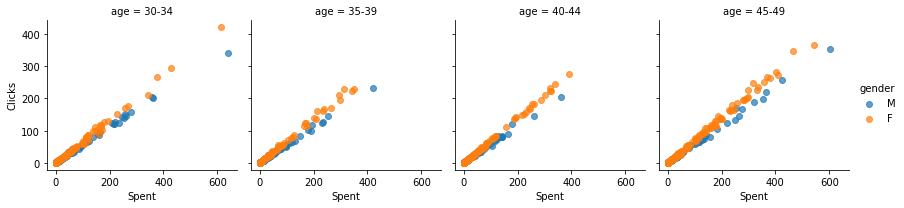

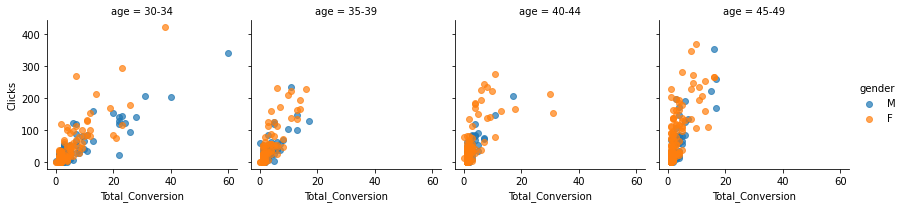

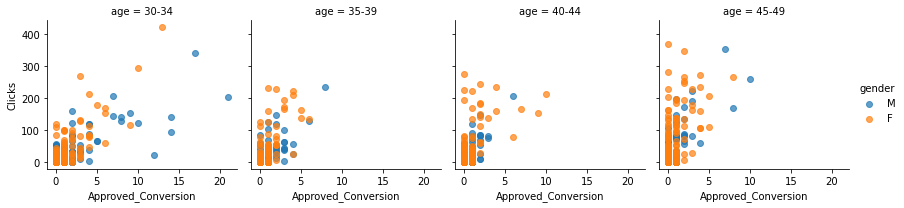

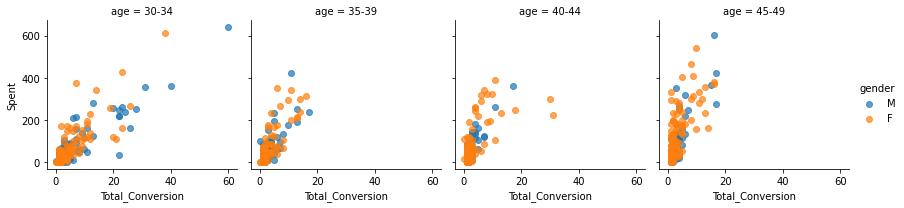

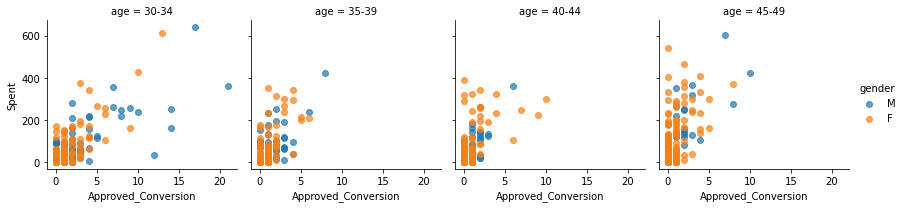

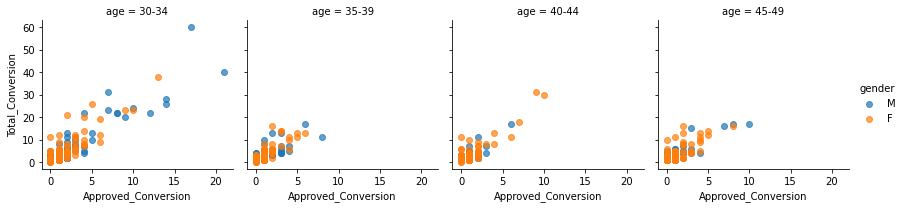

In [ ]:
for j in range(0,len(numeric_var)):
  for i in range(j+1,len(numeric_var)):
    g = sns.FacetGrid(df, col='age', hue='gender')
    g.map(plt.scatter, numeric_var[i], numeric_var[j], alpha=.7)
    g.add_legend();
  col=df.columns.values

These plots verify the points mentioned above. In addition we see that
1. Women of age group 40-44 clicked more and were converted more than men too.

We can also check-out pair-plots for similar information.


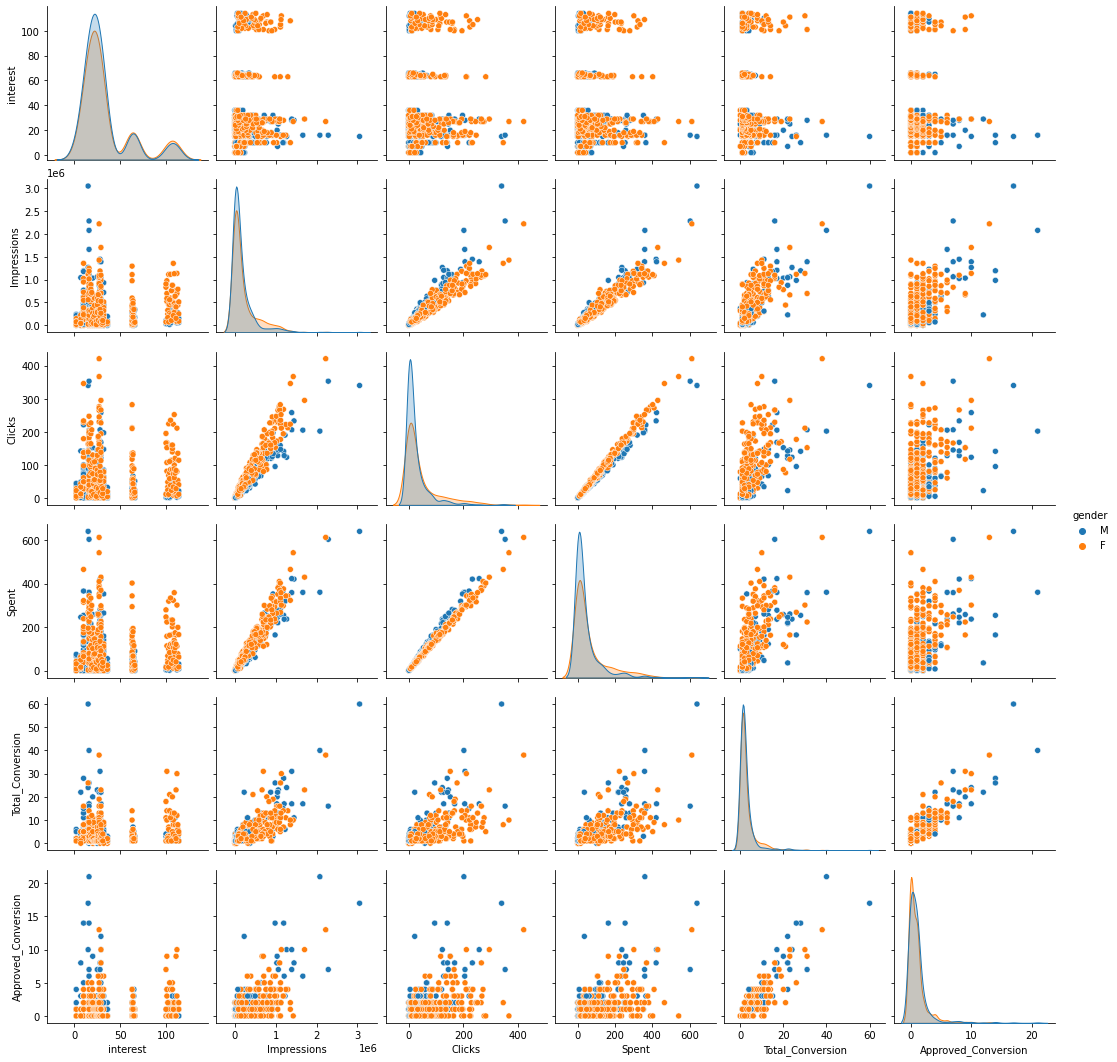

In [12]:
df1=df.drop(['ad_id', 'xyz_campaign_id', 'fb_campaign_id'],axis=1)
g = sns.pairplot(data=df1.iloc[:,1:],hue='gender', height=2.5)


Further inferences from above plots are following:
1. Conversion per click is more in males than females.
2. Approved conversion has interests clusterd between 0 and 50. 

Having a pciture of correlation matrix may come handy in picking correct metrics to introduce desirable changes. 

Also it is useful in identifying the correlation that requires special attention for example the case of multi-collinearity.   

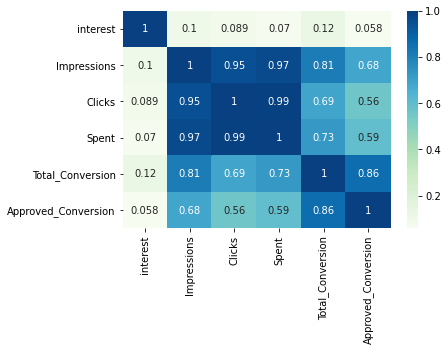

In [13]:
correlation=df1.corr()
sns.heatmap(correlation,cmap='GnBu',annot=True)

Correlation matrix gives us following infomation:

1. Impression has strong correlation with all numeric variables which is obvious.

2. Impression, click and spent have very high correlations.

3. There is 0.6 correlation of click and spent with approved conversion. Does this mean anything! Looks like our ads are putting some effort but not sufficient.

4. There is some limited scope of improving on Impressions/Click relation. Which in turn will improve Total conversions and hence Approved conversions. Impression can improve the conversion.

Histograms can also reveal some information. Lets plot histograms with frequency as numeric variables, bins as 'age'-group and hue as 'gender' for different campaigns. 

this is to see the nature of different campaigns and their target clients.

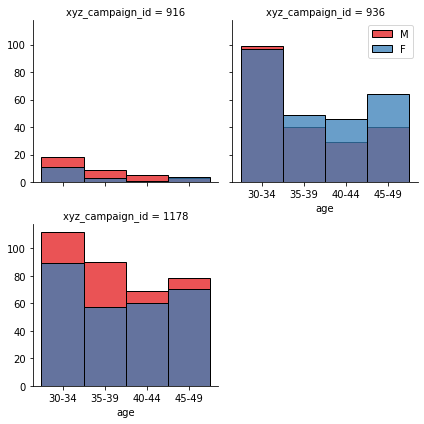

In [14]:
bins = 4
g = sns.FacetGrid(df, col="xyz_campaign_id",hue="gender", palette="Set1", col_wrap=2)
g.map(sns.histplot,'age',bins=bins)
g.axes[1].legend()
# plt.show()
# for i in range(0,len(cat_var)):
#   for j in range(0,len(numeric_var)):
#     sns.catplot(x='Approved_Conversion', y='Clicks',hue="gender", col="age",kind="bar",data=df,col_wrap=2)  


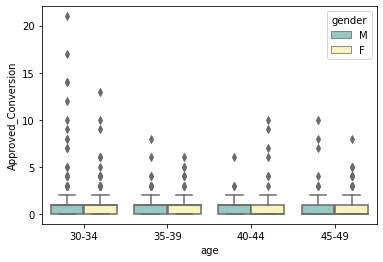

In [15]:
# the boxplot can be helpful in identifying outliers
ax = sns.boxplot(x="age", y="Approved_Conversion", hue="gender",
                 data=df, palette="Set3")

Inferences:
Campaign participation of men women and total participation distribution can be seen in different age groups of different genders. For example campaign 936 has more female participation.

This tells me to further analyse the histograms to check interests of men and woman of different age groups, or, we may also want to know the total conversion with age groups.



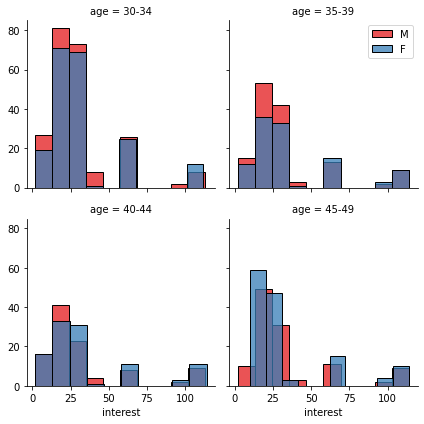

In [ ]:
bins=10
g=sns.FacetGrid(df, col='age',hue='gender',palette="Set1", col_wrap=2)
g.map(sns.histplot, 'interest',bins=bins)
g.axes[1].legend()
# for i in range(0,len(cat_var)):
#   for j in range(0,len(numeric_var)):
#     sns.catplot(x=cat_var[i], y=numeric_var[j],hue="age", col="gender",kind="bar",data=df,col_wrap=2) 

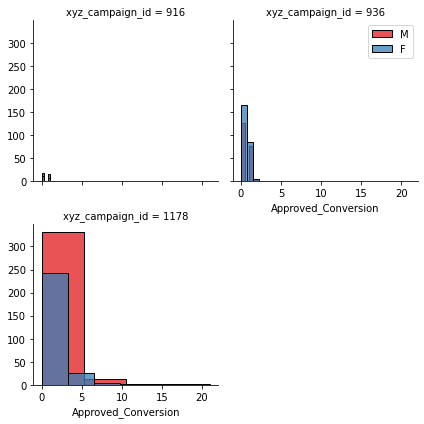

In [36]:
bins=4
g=sns.FacetGrid(df, col='xyz_campaign_id',hue='gender',palette="Set1", col_wrap=2)
g.map(sns.histplot, 'Approved_Conversion',bins=bins)
g.axes[1].legend()

These histogrms like previous plots also confirm majority of client base has interests associated with numbers in 0-40.

Women have special interests in numbers falling near or above 100.

All the conclusion from differnt plots provide information for better client segmentation, and an insight to the campaign for optimizing different metrices in the pipeline. 

Dimensionality reduction is not required here as we have 11 variables (features) and there is no sparsity situation with features. 

Having known the data we may think of classification in couple of ways.

1. Purely SVM approach:

We can directly apply SVM svc multi-classification on the data.

2. K-mean and SVM svr

This has been claimed to be giving better quality of classification and computationally cheap too.

3. KNN classification

We will GO WITH BEST OF THE THREE!


Lets first assign numeric values to categoric variables. 

In [16]:
#we will give some numerical values to categories
df['gender'].replace(to_replace=['M','F'], value=[0,1],inplace=True)
df.head()
df['age'].replace(to_replace=['30-34', '35-39', '40-44', '45-49'], value=[0,1,2,3],inplace=True)



Method 1:

Here i am training testing a SVC model. Following are the considerations to set parameters.
1. Conversion class will be derived from approved_conversion class.
2. Looking at approved_conversion class we notice that 90% of the data is 1 or 0. Hence we are looking at it as imbalanced data problem. Here i will use some weights assigned to each predicted classes to highlight their importance.

3. I would choose 'rbf' kernel because visually approved_conversion looks clustered in specific areas.

4. We will record the time of execution in the entire process to compare it with other methods.

We will create a pipeline for preprocessing and SVM svc classification. Pipelines help in validation and streamlining the processes in a neat manner. 


In [20]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
preprocessor = Pipeline([("scaler", StandardScaler())])# we can also perform PCA here which is not required apparently.
# The pipeline can be used as any other estimator
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel='rbf',class_weight='balanced'))])



I will create a training and testing dataset using train_test_split method. We can check for parameters of train_test_split method. There are methods to separate train test data. 



In [21]:
from sklearn import svm
import numpy as np
from sklearn.model_selection import train_test_split
import time
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import f1_score

#add a class label which is the predicted value
#df['Conversion_class']=[1]*len(df['age'])
for i in range(len(df['age'])):
  if df.loc[i,'Approved_Conversion']==0:
    df.loc[i,'Conversion_class']=0
  elif df.loc[i,'Approved_Conversion']<2:
    df.loc[i,'Conversion_class']=1
  elif df['Approved_Conversion'][i]<3:
    df.loc[i,'Conversion_class']=2 
  else:
    df.loc[i,'Conversion_class']=3

df1=df.drop('Conversion_class',axis=1)
X=df1.values
X=np.nan_to_num(X)
Y=df['Conversion_class']
#record the time to compare it with other method
start_time=time.time()
# to avoids mixing of training testing data we can split it
X_train, X_test, y_train, y_test = train_test_split(X, Y,random_state=0)
pipe.fit(X_train, y_train)
Score=pipe.score(X_test,y_test)
#cross validation
for i in range(3,7):
  cv = ShuffleSplit(n_splits=i, test_size=0.2, random_state=0)
  scores = cross_val_score(pipe,X_train,y_train,cv=cv,scoring='f1_micro')

  pipe.fit(X_train,y_train)

  y_preds = pipe.predict(X_test)

  mean_f1 = f1_score(y_test, y_preds, average='micro')
  print(mean_f1)
end_time=time.time()
print(end_time-start_time)
print(Score)
print(Y)


0.9440559440559441
0.9440559440559441
0.9440559440559441
0.9440559440559441
0.7472703456878662
0.9440559440559441
0       1.0
1       0.0
2       0.0
3       0.0
4       1.0
       ... 
1138    2.0
1139    0.0
1140    0.0
1141    2.0
1142    2.0
Name: Conversion_class, Length: 1143, dtype: float64


In many scenarios high scores suggest overfitting  hence cross validation as cross_val_score method was deployed here.

Cross validation will also eliminate the requirement of separate validation data set.


Cross validation also suggest same score_.

I tried with different number of splits, but all giving same values. 

Should i think of other validation methods!

 


In [ ]:
df.groupby('Conversion_class').mean()

,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
Conversion_class,,,,,,,,,,,
0.0,9.420920e+05,1037.527728,129258.642218,1.316637,0.502683,30.740608,88276.987478,17.588551,26.394311,1.375671,0.000000
1.0,9.814065e+05,1065.116625,133139.990074,1.258065,0.449132,33.099256,131414.223325,23.665012,36.400720,1.992556,1.000000
2.0,1.139797e+06,1164.629834,149193.939227,1.116022,0.491713,38.281768,613967.182320,103.845304,161.775248,9.348066,3.734807


How can we improve it?

Can we try dropping some variables. PCA during preprocessing may help.

To be sure about the results and also in search of a faster method we will do clusterig and multiclass classification.

k mean may facilitates speedy and accurate classification. The idea is to provide a better predicted class 'Y'.

There are methods for finding out optimal number of clusters required. A well known method to define number of clusters in k-means, Elbow method.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


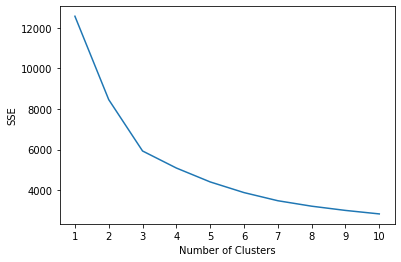

In [22]:
df=df.drop('Conversion_class',axis=1)
X=df.values
from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs 
from sklearn.preprocessing import StandardScaler
import numpy as np

X=np.nan_to_num(X)
Clus_dataSet = preprocessor.fit_transform(X)
Clus_dataSet
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"max_iter": 300,
"random_state": 42,
}
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(Clus_dataSet)
  sse.append(kmeans.inertia_)
#plot sse
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()


In [ ]:
pip install kneed

In [ ]:
from kneed import DataGenerator, KneeLocator
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
print(kl.elbow)

3


Elbow method suggests to go with 3 clusters.

We will apply kmeans on standardized dataset. For this also we can create a pipeline.

In [23]:
from sklearn.cluster import KMeans
import time
start_time=time.time()
clusterNum = 3
#create a k-mean pipeline
k_Mean=KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_mean=Pipeline([('k_means',k_Mean )])
preprocessor=Pipeline([('scaler', StandardScaler())])
pipe_kmean=Pipeline([('preprocess',preprocessor),('k_means',k_mean)])

#fit the entire dataset kmean.

pipe_kmean.fit(X) #
labels = pipe_kmean['k_means']['k_means'].labels_
y = labels #assign these labels to predicted y
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)
for i in range(3,7):
  cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
  scores = cross_val_score(pipe,X_train,y_train,cv=cv,scoring='f1_micro')

  pipe.fit(X_train,y_train)

  y_preds = pipe.predict(X_test)

  mean_f1 = f1_score(y_test, y_preds, average='micro')
end_time=time.time()
print(end_time-start_time)
print(mean_f1)

0.30412912368774414
0.993006993006993


Time of execution is significantly improved.
We see that we achieved better f1 scores than previous purely SVM svc model.

Such high cross validation scores suggest data being so vocal and structured.

Sufficient considerations of providing class weights and choice of kernel etc. have been made and the predictions are excellent to use with business. 

Hence we choose k-mean and svc classification.

Now we can have further visualization of kmean cluster data to fish some more information to help understand the campaign.

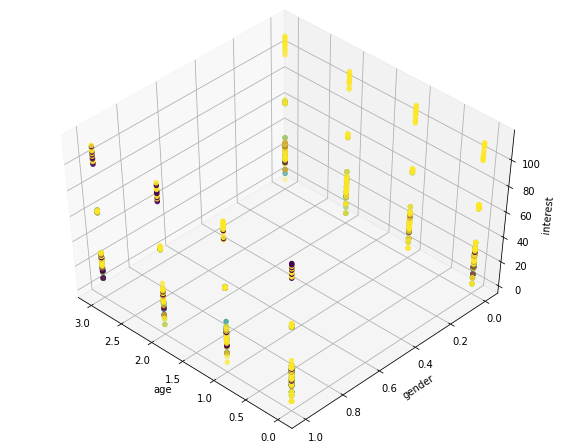

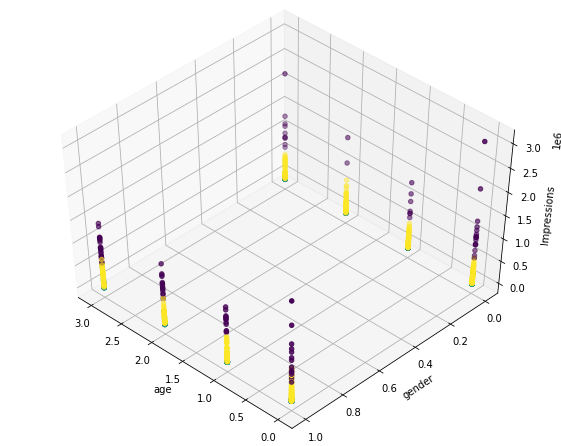

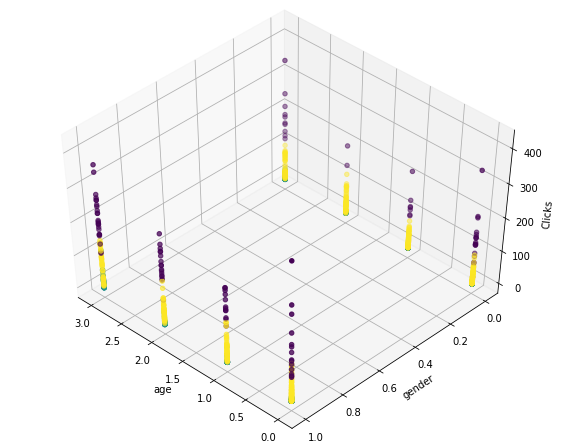

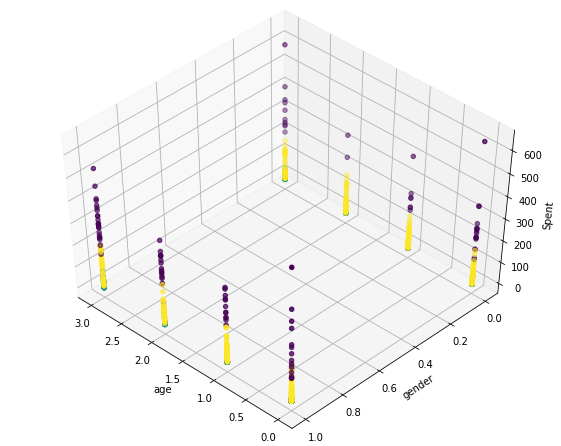

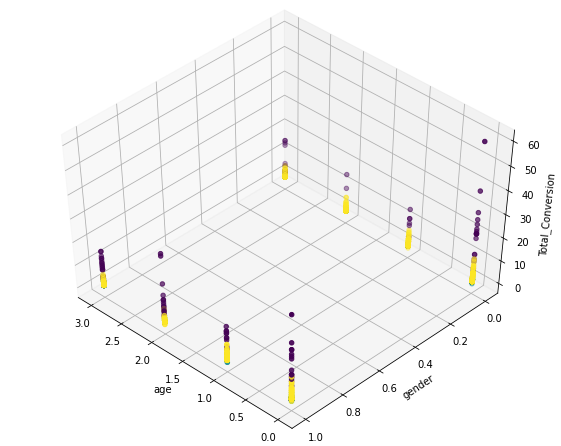

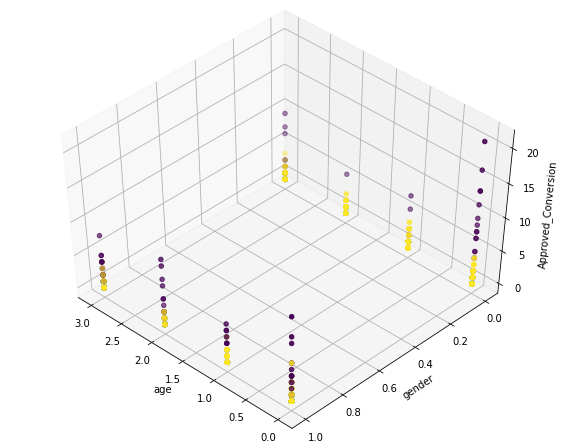

In [26]:
#check=df.groupby('Clus_km').mean()
#centers = k_means.cluster_centers_ 
from mpl_toolkits.mplot3d import Axes3D
l=1
cat_var=['gender','age']
for i in range(1,len(numeric_var)):
  fig = plt.figure(l, figsize=(8, 6))
  plt.clf()
  ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134) #rect is for [left,bottom,width,height]
  plt.cla()
  ax.set_xlabel('age')
  ax.set_ylabel('gender')
  ax.set_zlabel(numeric_var[i])
  col1=df.columns.get_loc('age')
  col2=df.columns.get_loc('gender')
  col3=df.columns.get_loc(numeric_var[i])
  ax.scatter(X[:, col1], X[:, col2], X[:, col3], c= labels.astype(np.float))
  l=l+1




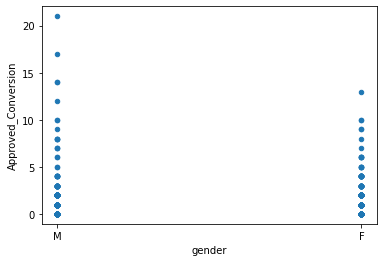

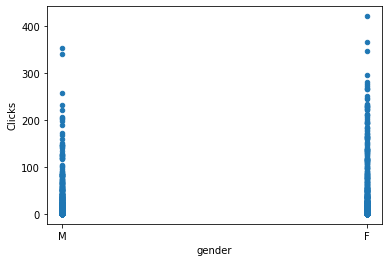

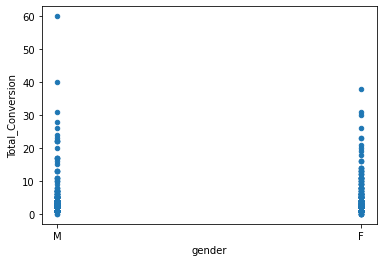

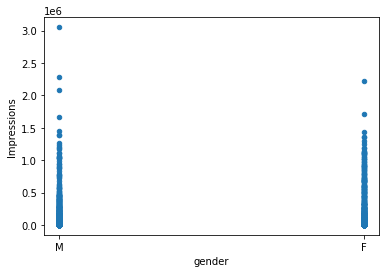

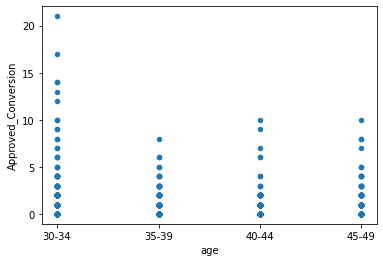

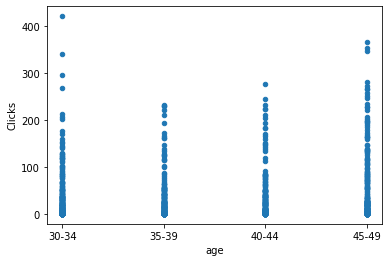

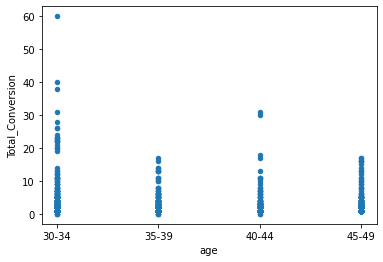

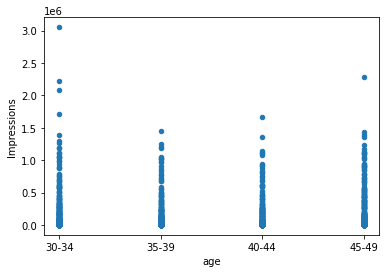

In [33]:
# To check quickly the scatter plot of one variables with other variables in using pandas plot too.  
df['gender'].replace(to_replace=[0,1], value=['M','F'],inplace=True)
df.head()
df['age'].replace(to_replace=[0,1,2,3], value=['30-34', '35-39', '40-44', '45-49'],inplace=True)
for i in range(0,len(cat_var)):
  df.plot.scatter(cat_var[i],'Approved_Conversion')
  df.plot.scatter(cat_var[i],'Clicks')
  df.plot.scatter(cat_var[i],'Total_Conversion')
  df.plot.scatter(cat_var[i],'Impressions')
df.plot.scatter(,'Total_Conversion')

Here we are trying to see the cluster-wise distribution of variables.

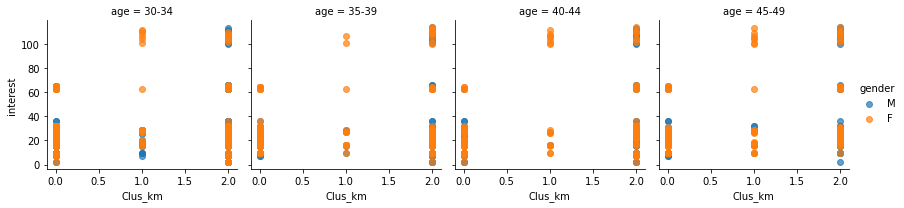

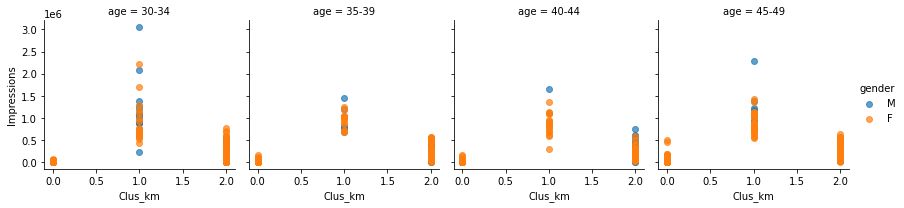

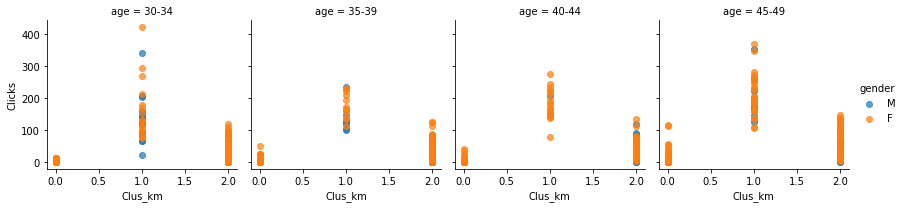

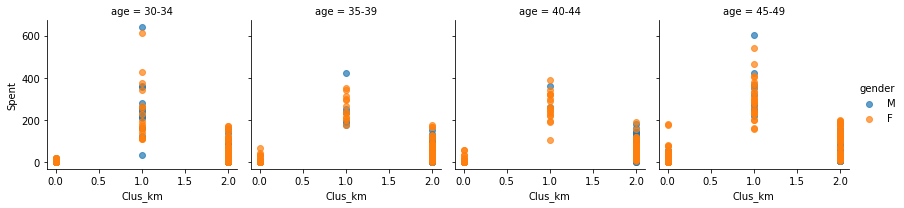

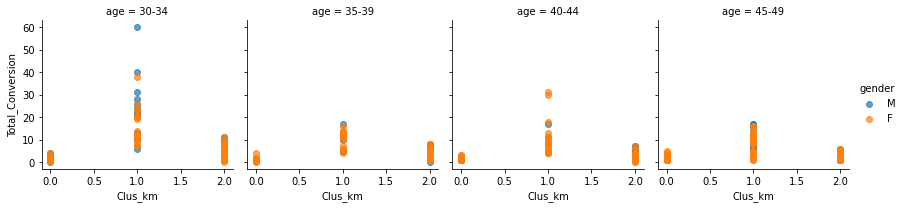

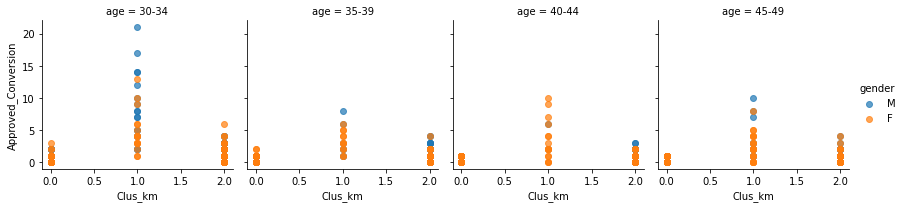

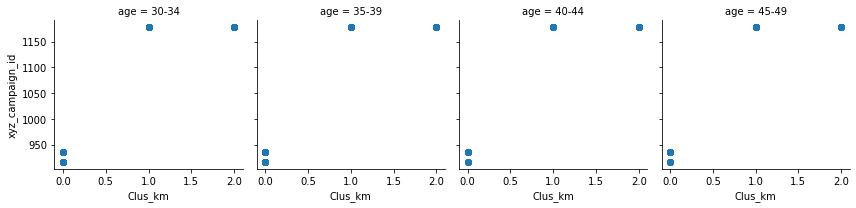

In [22]:
df['gender'].replace(to_replace=[0,1], value=['M','F'],inplace=True)
df.head()
df['age'].replace(to_replace=[0,1,2,3], value=['30-34', '35-39', '40-44', '45-49'],inplace=True)
df['Clus_km']=y
for i in range(1,len(numeric_var)):
  g = sns.FacetGrid(df, col='age', hue='gender')
  g.map(plt.scatter,'Clus_km',numeric_var[i], alpha=.7)
  g.add_legend();
g = sns.FacetGrid(df, col='age', hue=None)
g.map(plt.scatter,'Clus_km','xyz_campaign_id', alpha=.7)
col=df.columns.values

These scatter plots shown above reveal following information:
1. 2 of 3 campaigns fall in cluster 0 for all age group. So average conversion was least in these two campaigns.

2. Clusters have some intersections in all classes, but overall clicks and impressions which are 





In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn=Pipeline([('knn',knn )])
preprocessor=Pipeline([('scaler', StandardScaler())])
pipe_knn=Pipeline([('preprocess',preprocessor),('knn',knn)])

#fit the entire dataset kmean.

#pipe_knn.fit(X) #
#Classes = pipe_knn.['knn']['knn'].classes_
#y = labels #assign these labels to predicted y
start_time=time.time()
X_train, X_test, y_train, y_test = train_test_split(X, Y,random_state=0)
for i in range(3,7):
  cv = ShuffleSplit(n_splits=i, test_size=0.2, random_state=0)
  scores = cross_val_score(pipe_knn,X_train,y_train,cv=cv,scoring='f1_micro')

  pipe_knn.fit(X_train,y_train)

  y_preds = pipe_knn.predict(X_test)

  mean_f1 = f1_score(y_test, y_preds, average='micro')
  print(mean_f1)
end_time=time.time()
print(end_time-start_time)
classes=pipe_knn['knn']['knn'].classes_
print(classes)

0.7832167832167832
0.7832167832167832
0.7832167832167832
0.7832167832167832
0.31711912155151367
[0. 1. 2. 3.]


KNN is comparable to K mean and SVM classification in execution time.
f1 scores are however lower than other methods, but for KNN this score would be considered as good prediction.

Looking at the results of three methods, we can conclude that the K-means with SVM svc and class weight parameter is the most suitable and computationally efficient model.


Conclusion:
1. Improving on Imoression will certainly improve the approved conversions, however in some age groups it is observed that the clicks are not getting converted which means either the ad is not communicating or the the product needs to be customized for that age group.
2. The gap between total conversion and approved conversion needs to be filled. We can try NLP of phone conversation records for this purpose.
3. There are certain interests areas liked more by women than men. Quality of ads may play important role there to improve clicks and hence the conversions.
4. In general women click on ads more and get converted less than men, except in age group 40-44.
5. SVM classification with K-means clustering is very accurately predicting the client conversion. Model testing results are good and when compared with other classification methods this is most suitable method.
